In [8]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset, get_train_test
from src.eval import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [11]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [12]:
learning_rate = 0.003
num_epochs = 1
batch_size = 20

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.3

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [13]:
train_dataset, test_dataset = get_train_test()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

Initializing dataset
Initializing dataset


## Set up training tools

In [14]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Train detector



Starting epoch 1 / 1
Learning Rate for this epoch: 0.001
0 / 8163
Epoch [1/1], Iter [100/8163], Loss: total=191.681, reg=24.517, containing_obj=27.784, no_obj=33.800, cls=31.173
100 / 8163
Epoch [1/1], Iter [200/8163], Loss: total=177.737, reg=22.643, containing_obj=30.193, no_obj=16.900, cls=29.260
200 / 8163
Epoch [1/1], Iter [300/8163], Loss: total=171.489, reg=21.572, containing_obj=31.959, no_obj=11.267, cls=28.288
300 / 8163
Epoch [1/1], Iter [400/8163], Loss: total=167.937, reg=20.974, containing_obj=32.931, no_obj=8.450, cls=27.600
400 / 8163
Epoch [1/1], Iter [500/8163], Loss: total=165.297, reg=20.544, containing_obj=33.449, no_obj=6.760, cls=27.099
500 / 8163
Epoch [1/1], Iter [600/8163], Loss: total=162.946, reg=20.132, containing_obj=34.073, no_obj=5.633, cls=26.525
600 / 8163
Epoch [1/1], Iter [700/8163], Loss: total=161.799, reg=19.872, containing_obj=34.690, no_obj=4.829, cls=26.298
700 / 8163
Epoch [1/1], Iter [800/8163], Loss: total=160.342, reg=19.577, containing_o

100%|██████████| 492/492 [00:03<00:00, 149.83it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=5.073, reg=0.740, containing_obj=0.792, no_obj=0.000, cls=0.583
Updating best test loss: 2495.88598
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


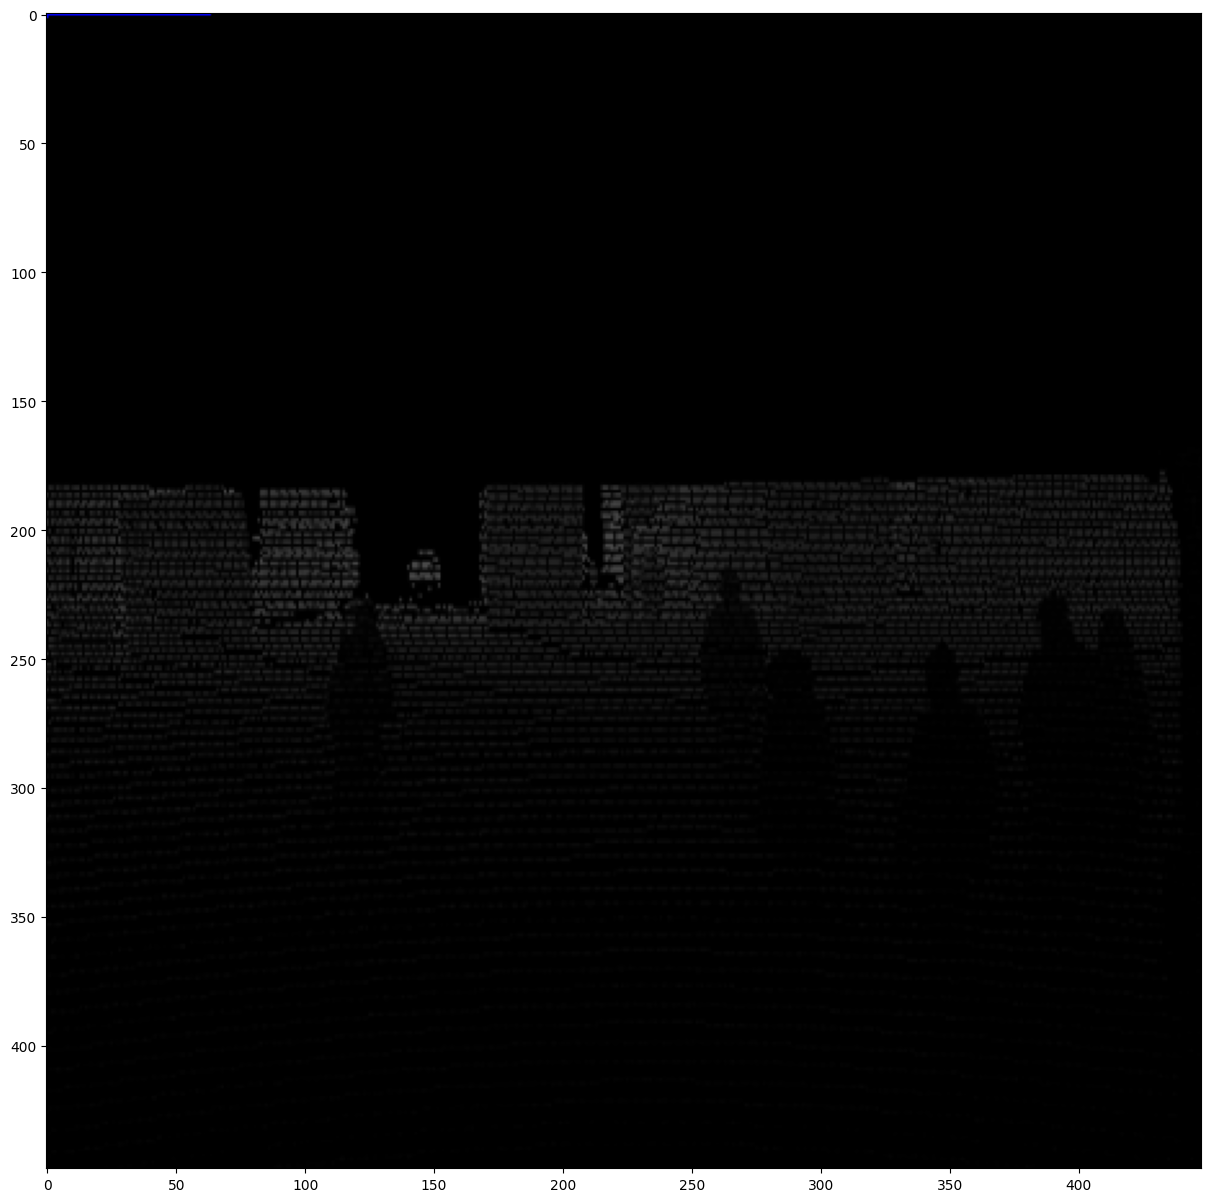

1000 / 8163
Epoch [1/1], Iter [1100/8163], Loss: total=157.158, reg=18.880, containing_obj=36.706, no_obj=3.073, cls=25.132
1100 / 8163
Epoch [1/1], Iter [1200/8163], Loss: total=155.997, reg=18.660, containing_obj=37.098, no_obj=2.817, cls=24.756
1200 / 8163
Epoch [1/1], Iter [1300/8163], Loss: total=154.633, reg=18.418, containing_obj=37.343, no_obj=2.600, cls=24.421
1300 / 8163
Epoch [1/1], Iter [1400/8163], Loss: total=153.742, reg=18.236, containing_obj=37.700, no_obj=2.414, cls=24.139
1400 / 8163
Epoch [1/1], Iter [1500/8163], Loss: total=152.859, reg=18.053, containing_obj=38.046, no_obj=2.253, cls=23.871
1500 / 8163
Epoch [1/1], Iter [1600/8163], Loss: total=151.975, reg=17.877, containing_obj=38.343, no_obj=2.112, cls=23.613
1600 / 8163
Epoch [1/1], Iter [1700/8163], Loss: total=151.249, reg=17.713, containing_obj=38.598, no_obj=1.988, cls=23.490
1700 / 8163
Epoch [1/1], Iter [1800/8163], Loss: total=150.854, reg=17.595, containing_obj=38.985, no_obj=1.878, cls=23.330
1800 / 8

100%|██████████| 492/492 [00:03<00:00, 151.36it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.441, reg=0.619, containing_obj=0.929, no_obj=0.000, cls=0.415
Updating best test loss: 2185.15704
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


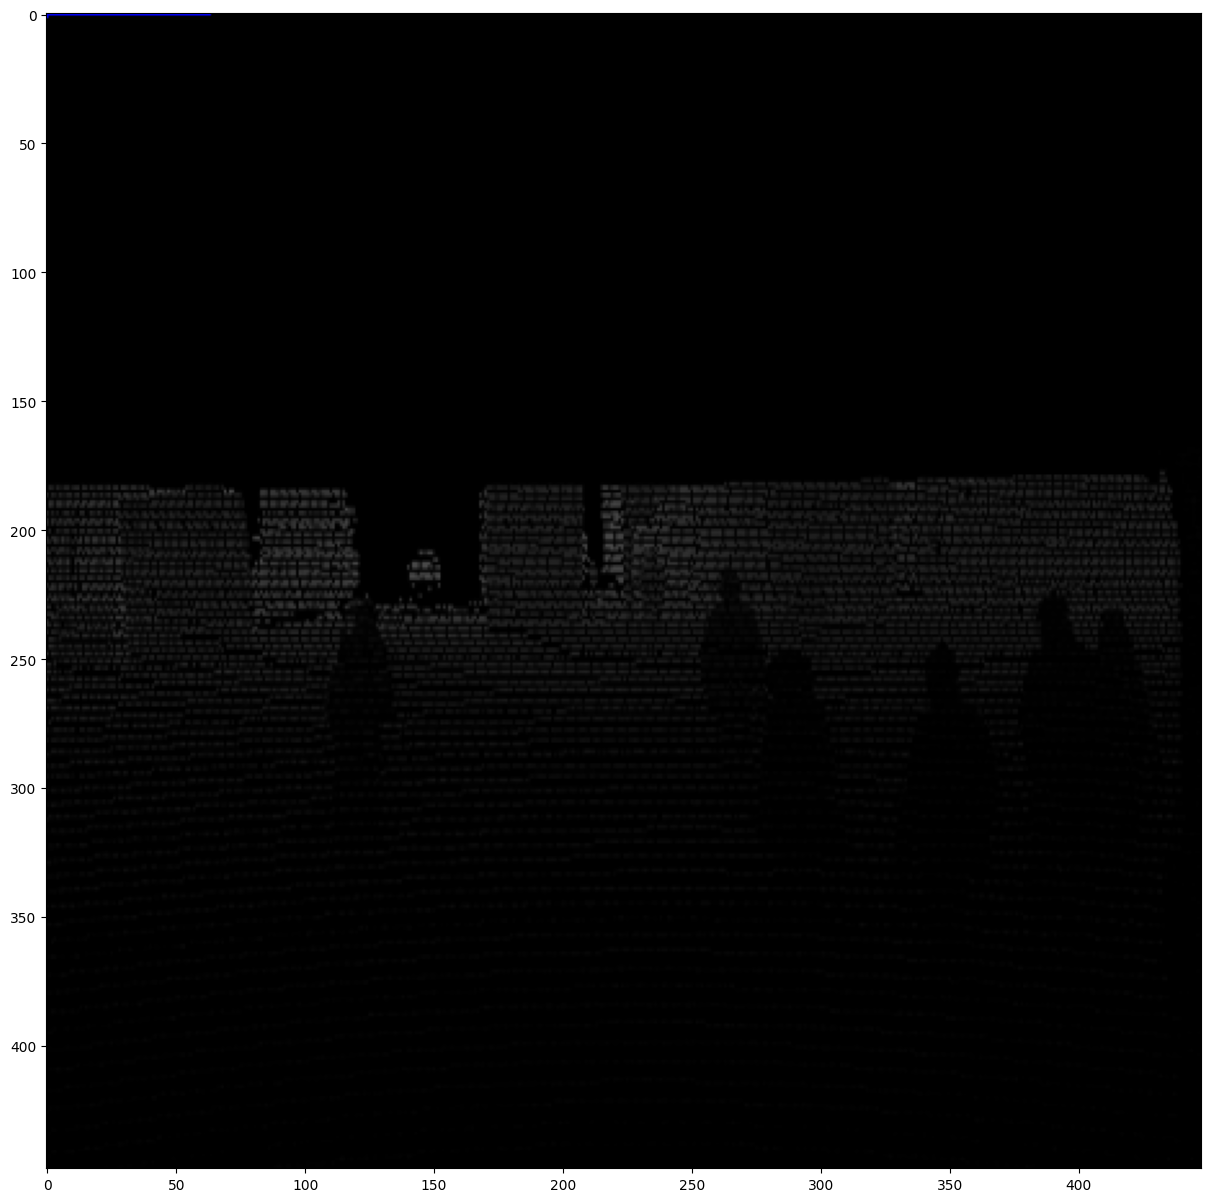

2000 / 8163
Epoch [1/1], Iter [2100/8163], Loss: total=148.705, reg=17.144, containing_obj=39.754, no_obj=1.610, cls=22.746
2100 / 8163
Epoch [1/1], Iter [2200/8163], Loss: total=147.918, reg=17.017, containing_obj=39.699, no_obj=1.805, cls=22.593
2200 / 8163
Epoch [1/1], Iter [2300/8163], Loss: total=146.880, reg=16.906, containing_obj=39.200, no_obj=2.387, cls=22.434
2300 / 8163
Epoch [1/1], Iter [2400/8163], Loss: total=145.905, reg=16.810, containing_obj=38.644, no_obj=3.025, cls=22.303
2400 / 8163
Epoch [1/1], Iter [2500/8163], Loss: total=144.724, reg=16.696, containing_obj=38.003, no_obj=3.594, cls=22.160
2500 / 8163
Epoch [1/1], Iter [2600/8163], Loss: total=143.555, reg=16.584, containing_obj=37.405, no_obj=4.156, cls=21.985
2600 / 8163
Epoch [1/1], Iter [2700/8163], Loss: total=142.346, reg=16.464, containing_obj=36.821, no_obj=4.692, cls=21.799
2700 / 8163
Epoch [1/1], Iter [2800/8163], Loss: total=141.290, reg=16.357, containing_obj=36.306, no_obj=5.184, cls=21.645
2800 / 8

100%|██████████| 492/492 [00:03<00:00, 151.35it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.562, reg=0.629, containing_obj=0.525, no_obj=0.990, cls=0.595
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


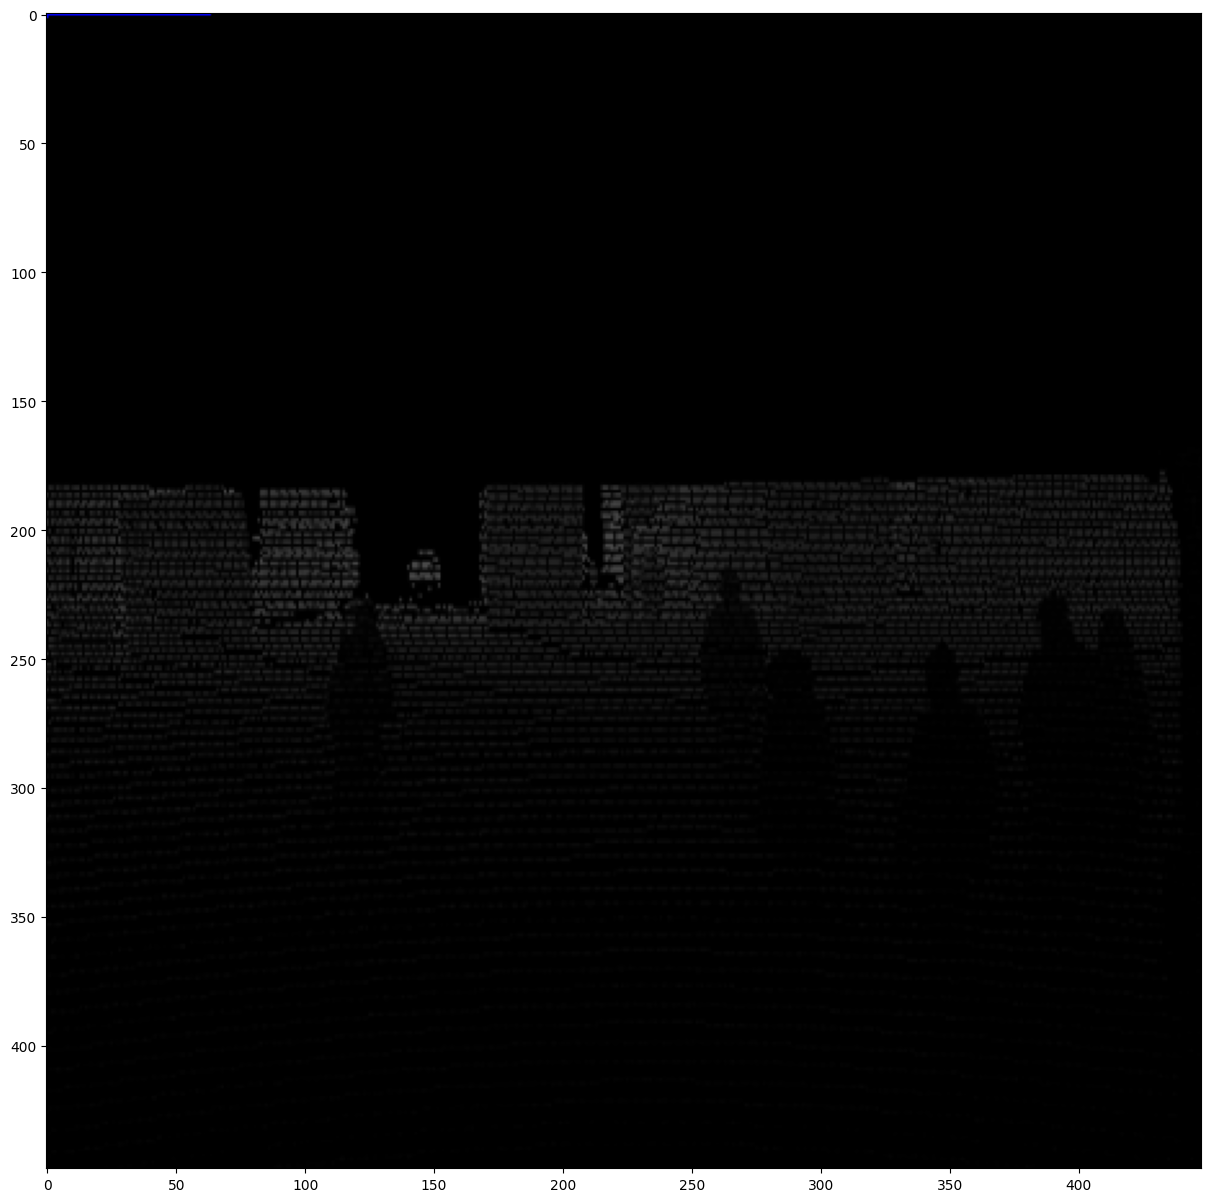

3000 / 8163
Epoch [1/1], Iter [3100/8163], Loss: total=138.246, reg=16.036, containing_obj=34.884, no_obj=6.497, cls=21.232
3100 / 8163
Epoch [1/1], Iter [3200/8163], Loss: total=137.204, reg=15.921, containing_obj=34.464, no_obj=6.883, cls=21.071
3200 / 8163
Epoch [1/1], Iter [3300/8163], Loss: total=136.180, reg=15.809, containing_obj=34.062, no_obj=7.226, cls=20.907
3300 / 8163
Epoch [1/1], Iter [3400/8163], Loss: total=135.305, reg=15.715, containing_obj=33.688, no_obj=7.562, cls=20.773
3400 / 8163
Epoch [1/1], Iter [3500/8163], Loss: total=134.286, reg=15.596, containing_obj=33.321, no_obj=7.876, cls=20.621
3500 / 8163
Epoch [1/1], Iter [3600/8163], Loss: total=133.340, reg=15.494, containing_obj=32.958, no_obj=8.168, cls=20.464
3600 / 8163
Epoch [1/1], Iter [3700/8163], Loss: total=132.462, reg=15.396, containing_obj=32.628, no_obj=8.438, cls=20.321
3700 / 8163
Epoch [1/1], Iter [3800/8163], Loss: total=131.572, reg=15.298, containing_obj=32.306, no_obj=8.700, cls=20.164
3800 / 8

100%|██████████| 492/492 [00:03<00:00, 151.43it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.041, reg=0.569, containing_obj=0.519, no_obj=1.001, cls=0.378
Updating best test loss: 1988.05243
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


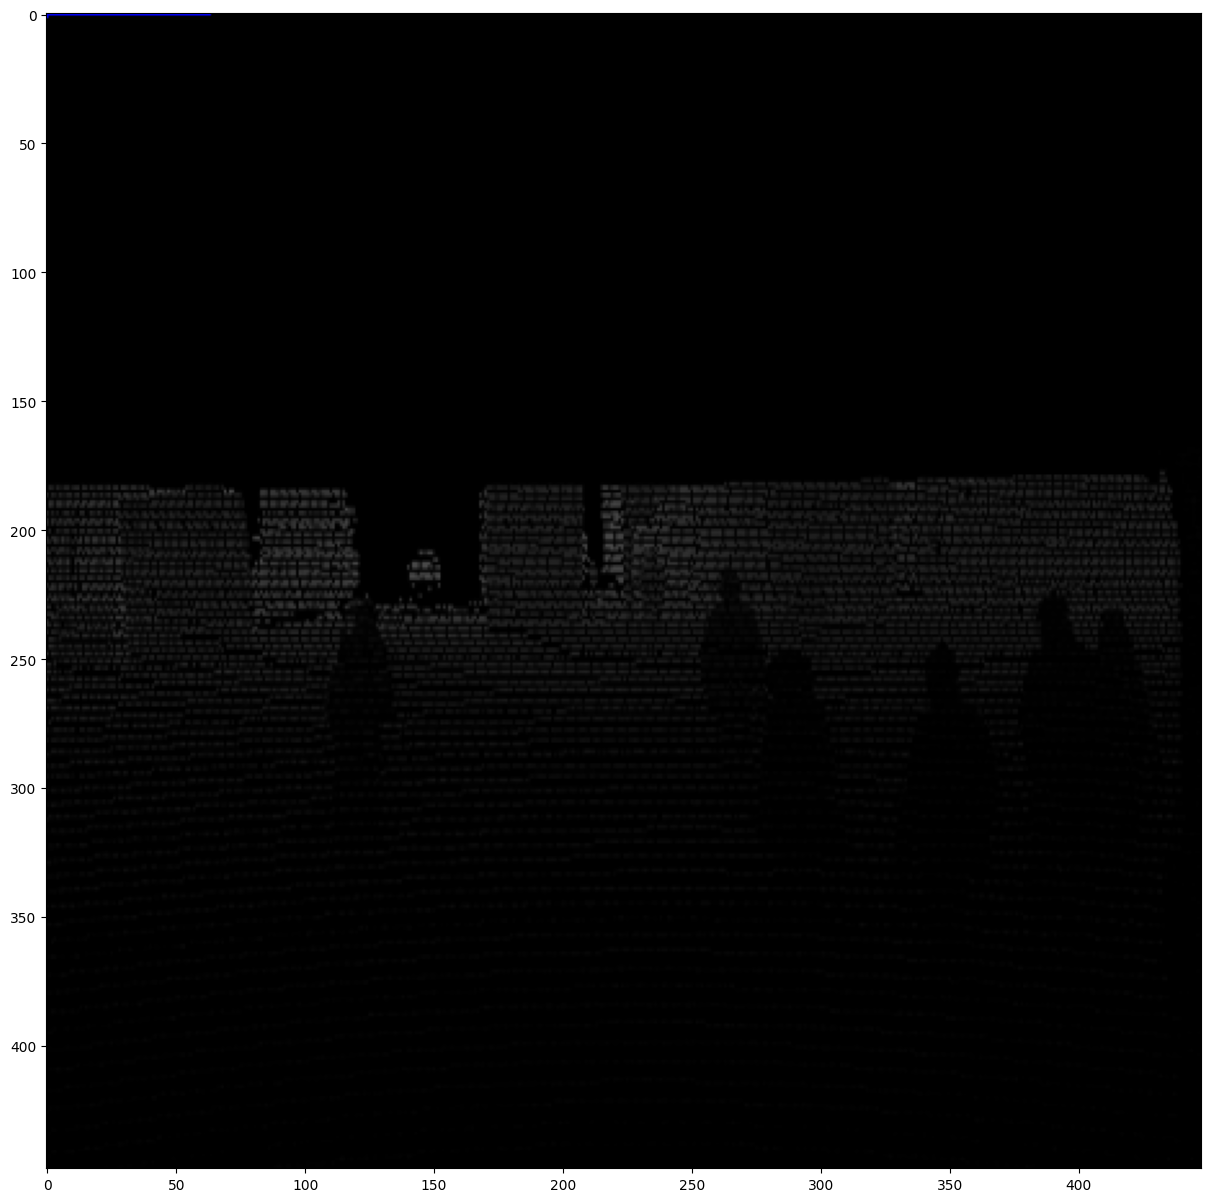

4000 / 8163
Epoch [1/1], Iter [4100/8163], Loss: total=129.210, reg=15.034, containing_obj=31.432, no_obj=9.410, cls=19.787
4100 / 8163
Epoch [1/1], Iter [4200/8163], Loss: total=128.528, reg=14.957, containing_obj=31.178, no_obj=9.620, cls=19.679
4200 / 8163
Epoch [1/1], Iter [4300/8163], Loss: total=127.874, reg=14.883, containing_obj=30.943, no_obj=9.823, cls=19.567
4300 / 8163
Epoch [1/1], Iter [4400/8163], Loss: total=127.198, reg=14.811, containing_obj=30.695, no_obj=10.027, cls=19.441
4400 / 8163
Epoch [1/1], Iter [4500/8163], Loss: total=126.615, reg=14.745, containing_obj=30.487, no_obj=10.203, cls=19.343
4500 / 8163
Epoch [1/1], Iter [4600/8163], Loss: total=126.023, reg=14.680, containing_obj=30.260, no_obj=10.389, cls=19.248
4600 / 8163
Epoch [1/1], Iter [4700/8163], Loss: total=125.442, reg=14.614, containing_obj=30.049, no_obj=10.566, cls=19.153
4700 / 8163
Epoch [1/1], Iter [4800/8163], Loss: total=124.851, reg=14.546, containing_obj=29.853, no_obj=10.726, cls=19.048
480

100%|██████████| 492/492 [00:03<00:00, 149.80it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.092, reg=0.571, containing_obj=0.513, no_obj=1.093, cls=0.393
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


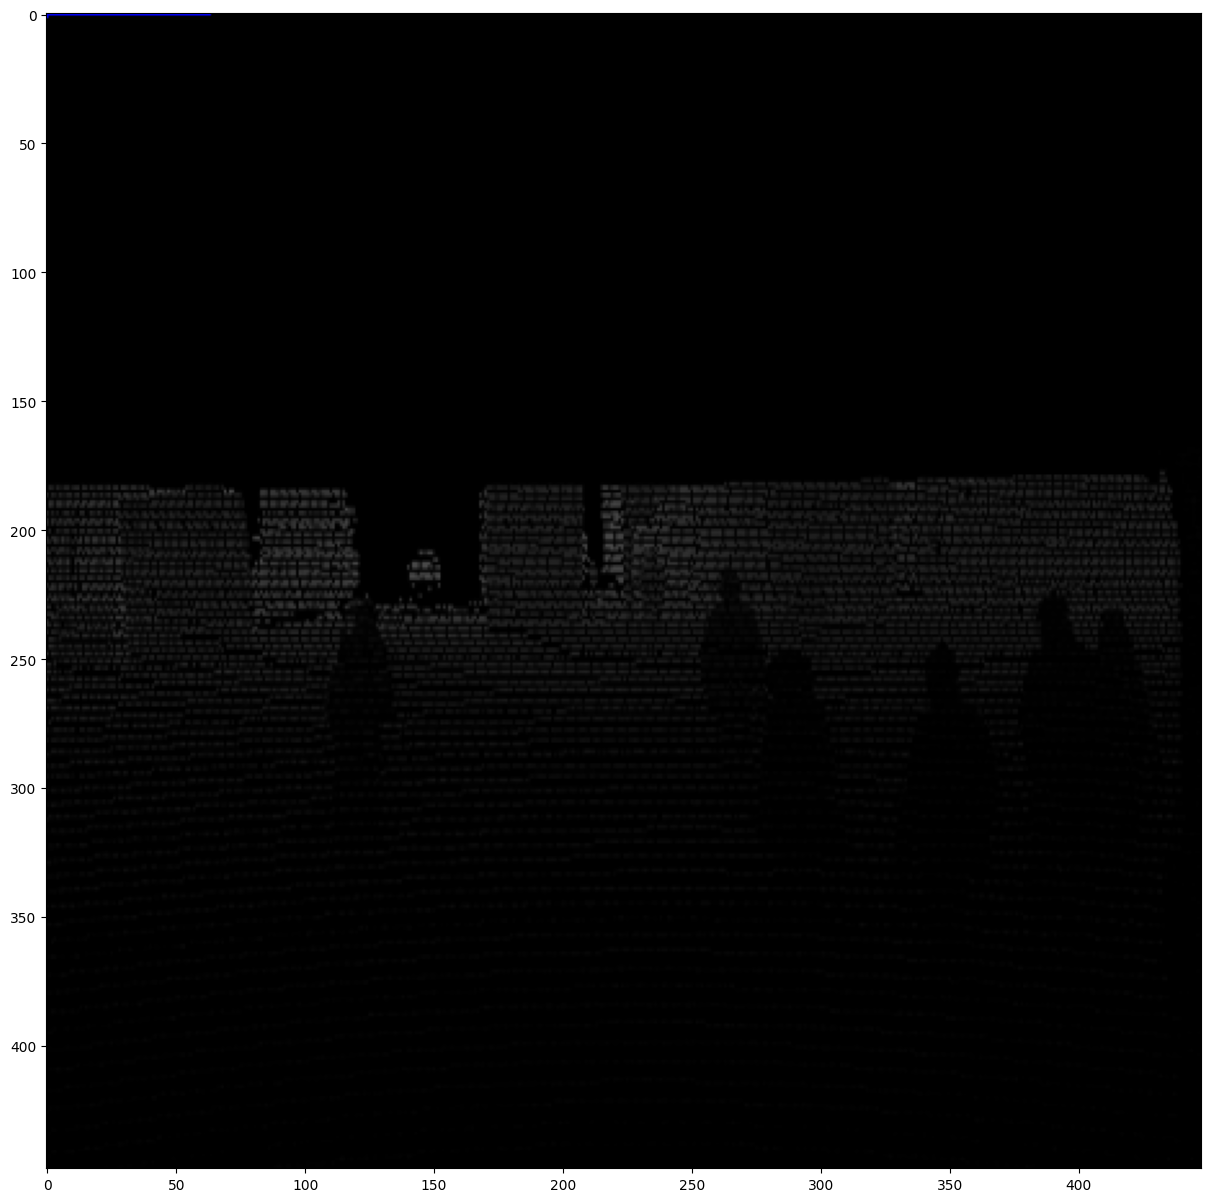

5000 / 8163
Epoch [1/1], Iter [5100/8163], Loss: total=123.541, reg=14.400, containing_obj=29.342, no_obj=11.180, cls=18.846
5100 / 8163
Epoch [1/1], Iter [5200/8163], Loss: total=123.130, reg=14.354, containing_obj=29.179, no_obj=11.319, cls=18.784
5200 / 8163
Epoch [1/1], Iter [5300/8163], Loss: total=122.652, reg=14.299, containing_obj=29.014, no_obj=11.442, cls=18.709
5300 / 8163
Epoch [1/1], Iter [5400/8163], Loss: total=122.243, reg=14.254, containing_obj=28.864, no_obj=11.567, cls=18.638
5400 / 8163
Epoch [1/1], Iter [5500/8163], Loss: total=121.780, reg=14.199, containing_obj=28.705, no_obj=11.685, cls=18.575
5500 / 8163
Epoch [1/1], Iter [5600/8163], Loss: total=121.358, reg=14.153, containing_obj=28.558, no_obj=11.804, cls=18.492
5600 / 8163
Epoch [1/1], Iter [5700/8163], Loss: total=121.035, reg=14.119, containing_obj=28.440, no_obj=11.926, cls=18.425
5700 / 8163
Epoch [1/1], Iter [5800/8163], Loss: total=120.679, reg=14.078, containing_obj=28.313, no_obj=12.034, cls=18.364


100%|██████████| 492/492 [00:03<00:00, 149.10it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.147, reg=0.576, containing_obj=0.513, no_obj=1.088, cls=0.427
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


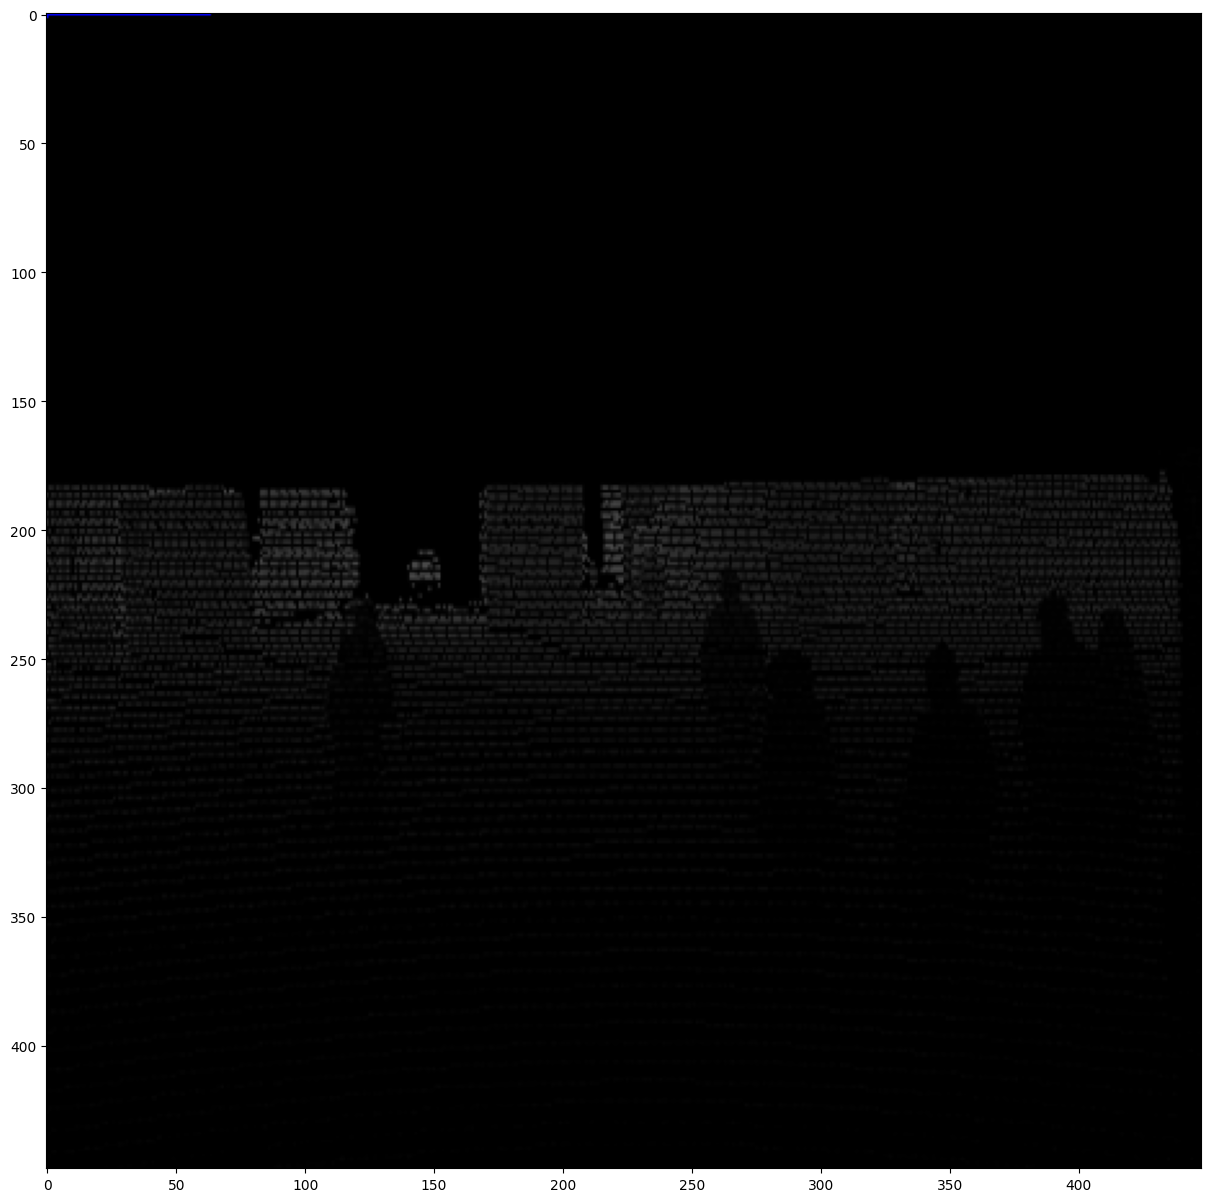

6000 / 8163
Epoch [1/1], Iter [6100/8163], Loss: total=119.597, reg=13.951, containing_obj=27.932, no_obj=12.360, cls=18.202
6100 / 8163
Epoch [1/1], Iter [6200/8163], Loss: total=119.202, reg=13.903, containing_obj=27.799, no_obj=12.459, cls=18.148
6200 / 8163
Epoch [1/1], Iter [6300/8163], Loss: total=118.866, reg=13.865, containing_obj=27.683, no_obj=12.551, cls=18.094
6300 / 8163
Epoch [1/1], Iter [6400/8163], Loss: total=118.559, reg=13.829, containing_obj=27.584, no_obj=12.635, cls=18.040
6400 / 8163
Epoch [1/1], Iter [6500/8163], Loss: total=118.221, reg=13.789, containing_obj=27.477, no_obj=12.722, cls=17.982
6500 / 8163
Epoch [1/1], Iter [6600/8163], Loss: total=117.835, reg=13.743, containing_obj=27.354, no_obj=12.804, cls=17.924
6600 / 8163
Epoch [1/1], Iter [6700/8163], Loss: total=117.543, reg=13.710, containing_obj=27.251, no_obj=12.878, cls=17.877
6700 / 8163
Epoch [1/1], Iter [6800/8163], Loss: total=117.256, reg=13.676, containing_obj=27.155, no_obj=12.957, cls=17.834


100%|██████████| 492/492 [00:03<00:00, 150.10it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.019, reg=0.570, containing_obj=0.517, no_obj=0.975, cls=0.360
Updating best test loss: 1977.54495
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


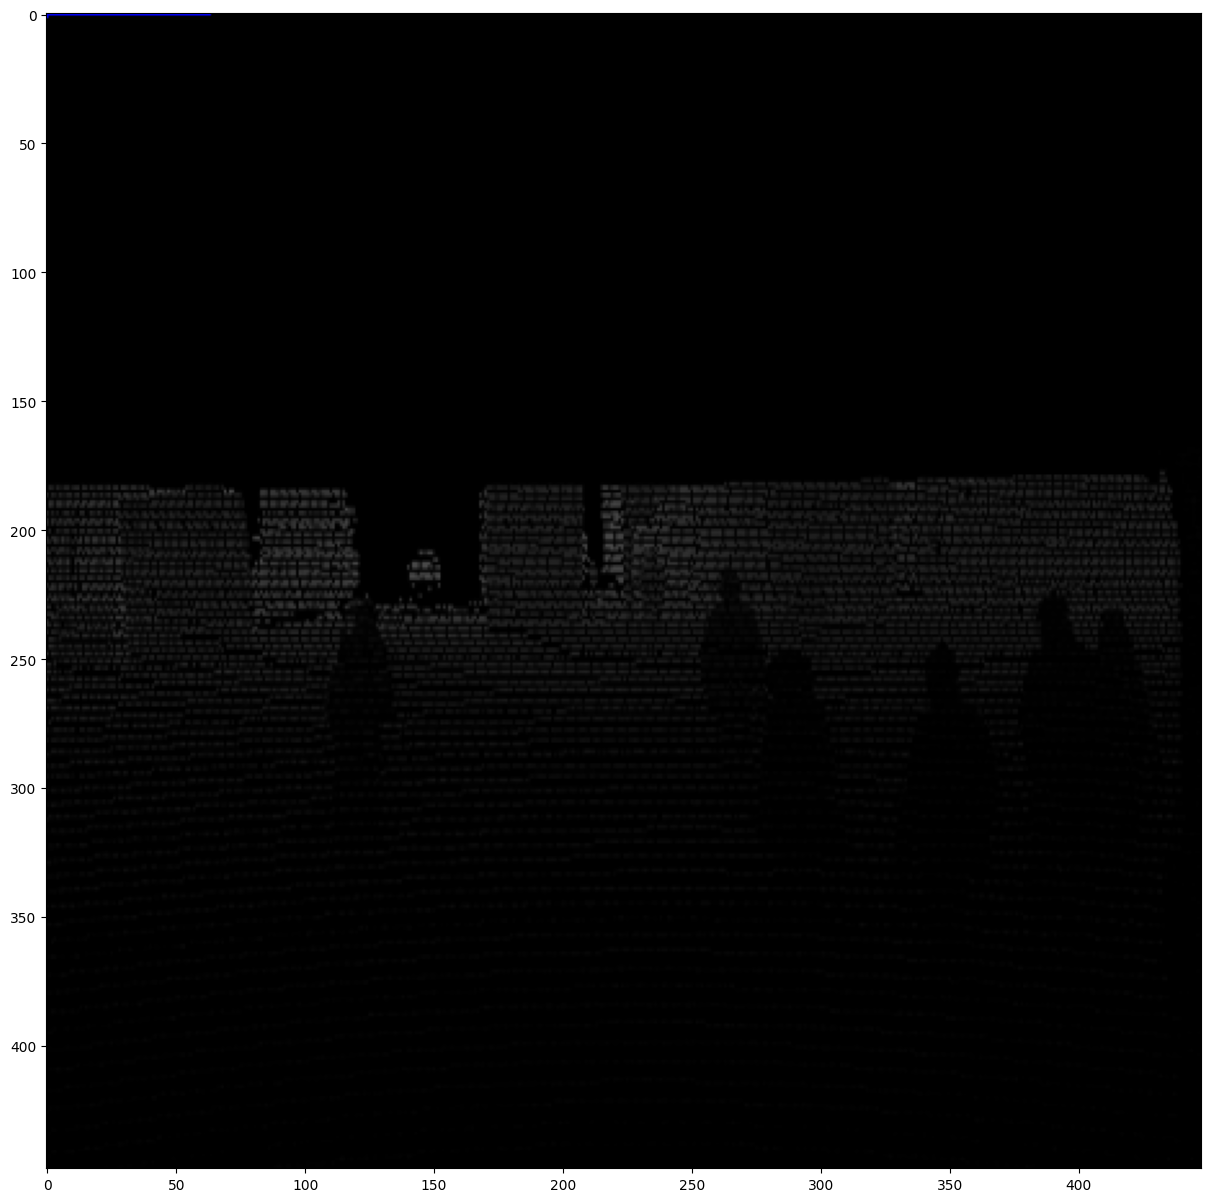

7000 / 8163
Epoch [1/1], Iter [7100/8163], Loss: total=116.373, reg=13.573, containing_obj=26.874, no_obj=13.182, cls=17.677
7100 / 8163
Epoch [1/1], Iter [7200/8163], Loss: total=116.123, reg=13.546, containing_obj=26.793, no_obj=13.250, cls=17.625
7200 / 8163
Epoch [1/1], Iter [7300/8163], Loss: total=115.840, reg=13.514, containing_obj=26.697, no_obj=13.321, cls=17.575
7300 / 8163
Epoch [1/1], Iter [7400/8163], Loss: total=115.579, reg=13.483, containing_obj=26.612, no_obj=13.387, cls=17.534
7400 / 8163
Epoch [1/1], Iter [7500/8163], Loss: total=115.312, reg=13.452, containing_obj=26.526, no_obj=13.454, cls=17.489
7500 / 8163
Epoch [1/1], Iter [7600/8163], Loss: total=115.088, reg=13.425, containing_obj=26.445, no_obj=13.517, cls=17.460
7600 / 8163
Epoch [1/1], Iter [7700/8163], Loss: total=114.868, reg=13.400, containing_obj=26.375, no_obj=13.581, cls=17.420
7700 / 8163
Epoch [1/1], Iter [7800/8163], Loss: total=114.630, reg=13.371, containing_obj=26.297, no_obj=13.635, cls=17.386


100%|██████████| 492/492 [00:03<00:00, 149.91it/s]


---class vehicle ap 0.0---
---class pedestrian ap 0.0--- (no predictions for this class)
---class cyclist ap 0.0--- (no predictions for this class)
---map 0.0---
0 [0.0, 0.0, 0.0]
Epoch [1/1], Iter [492/492], Loss: total=4.040, reg=0.570, containing_obj=0.519, no_obj=0.992, cls=0.372
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


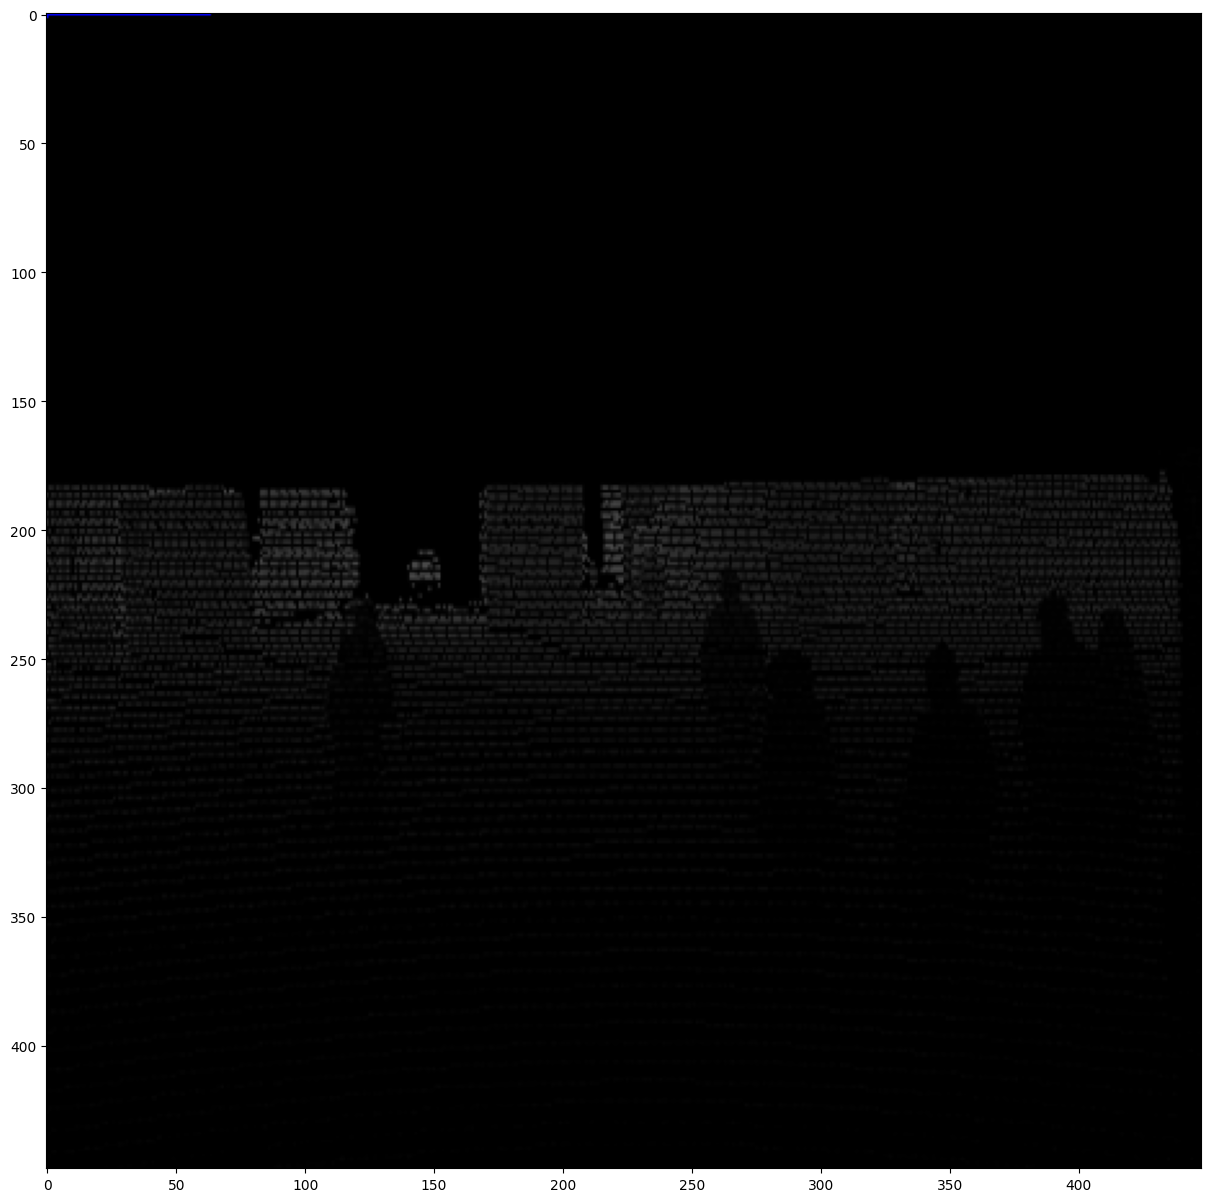

8000 / 8163
Epoch [1/1], Iter [8100/8163], Loss: total=113.993, reg=13.300, containing_obj=26.080, no_obj=13.812, cls=17.269
8100 / 8163


In [15]:
best_test_loss = np.inf
learning_rate = 0.001
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):


        if i == 3000 or i == 6000:
            learning_rate /= 10.0

            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate


        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map, dimg = data
        pred = net(dimg.type(torch.FloatTensor).to('cuda'))
        if(i % 100 == 0):
            print(i, "/", len(train_loader))
        # print(pred[:, :, :, -20:])
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
        if (i+1) % 1000 == 0:
            print('evaluating')
            test_aps = evaluate(net, test_loader)
            print(epoch, test_aps)
            with torch.no_grad():
                test_loss = collections.defaultdict(int)
                net.eval()
                for i, data in enumerate(test_loader):
                    data = (item.to(device) for item in data)
                    images, target_boxes, target_cls, has_object_map, dimg, bxs, lbls = data
                    
                    pred = net(dimg.type(torch.FloatTensor).cuda())
                    loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
                    for key in loss_dict:
                        test_loss[key] += loss_dict[key].item()
            
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(test_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in test_loss.items() )
            print(outstring)
            if best_test_loss > test_loss['total_loss']:
                best_test_loss = test_loss['total_loss']
                print('Updating best test loss: %.5f' % best_test_loss)
                torch.save(net.state_dict(),'checkpoints/best_detector2_late.pth')

            image_name = "test"
            dimg = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_depth_1.jpg', cv2.IMREAD_GRAYSCALE)
            
            dimg_small = torch.nn.MaxPool2d((4,4), stride=(4,4))(torch.unsqueeze(torch.unsqueeze(torch.tensor(dimg, dtype=torch.float), axis=0), axis=0)).repeat((1,3,1,1))
            dimg_small = dimg_small[0].permute(1,2,0).numpy()
            image = cv2.resize(dimg_small, (448, 448))

            print('predicting...')
            result = predict_image(net, image, image_name=1)
            print(result)
            for left_up, right_bottom, class_name, _, prob in result:
                color = COLORS[VOC_CLASSES.index(class_name)]
                cv2.rectangle(image, left_up, right_bottom, color, 2)
                label = class_name + str(round(prob, 2))
                text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
                p1 = (left_up[0], left_up[1] - text_size[1])
                cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                            color, -1)
                cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

            plt.figure(figsize = (15,15))
            plt.imshow(image.astype(np.int32))
            plt.show()


        net.train()

    torch.save(net.state_dict(),'checkpoints/detector2_late.pth')
    


# View example predictions

predicting...
[[(108, 224), (129, 328), 'vehicle', 1, 0.14382407069206238]]


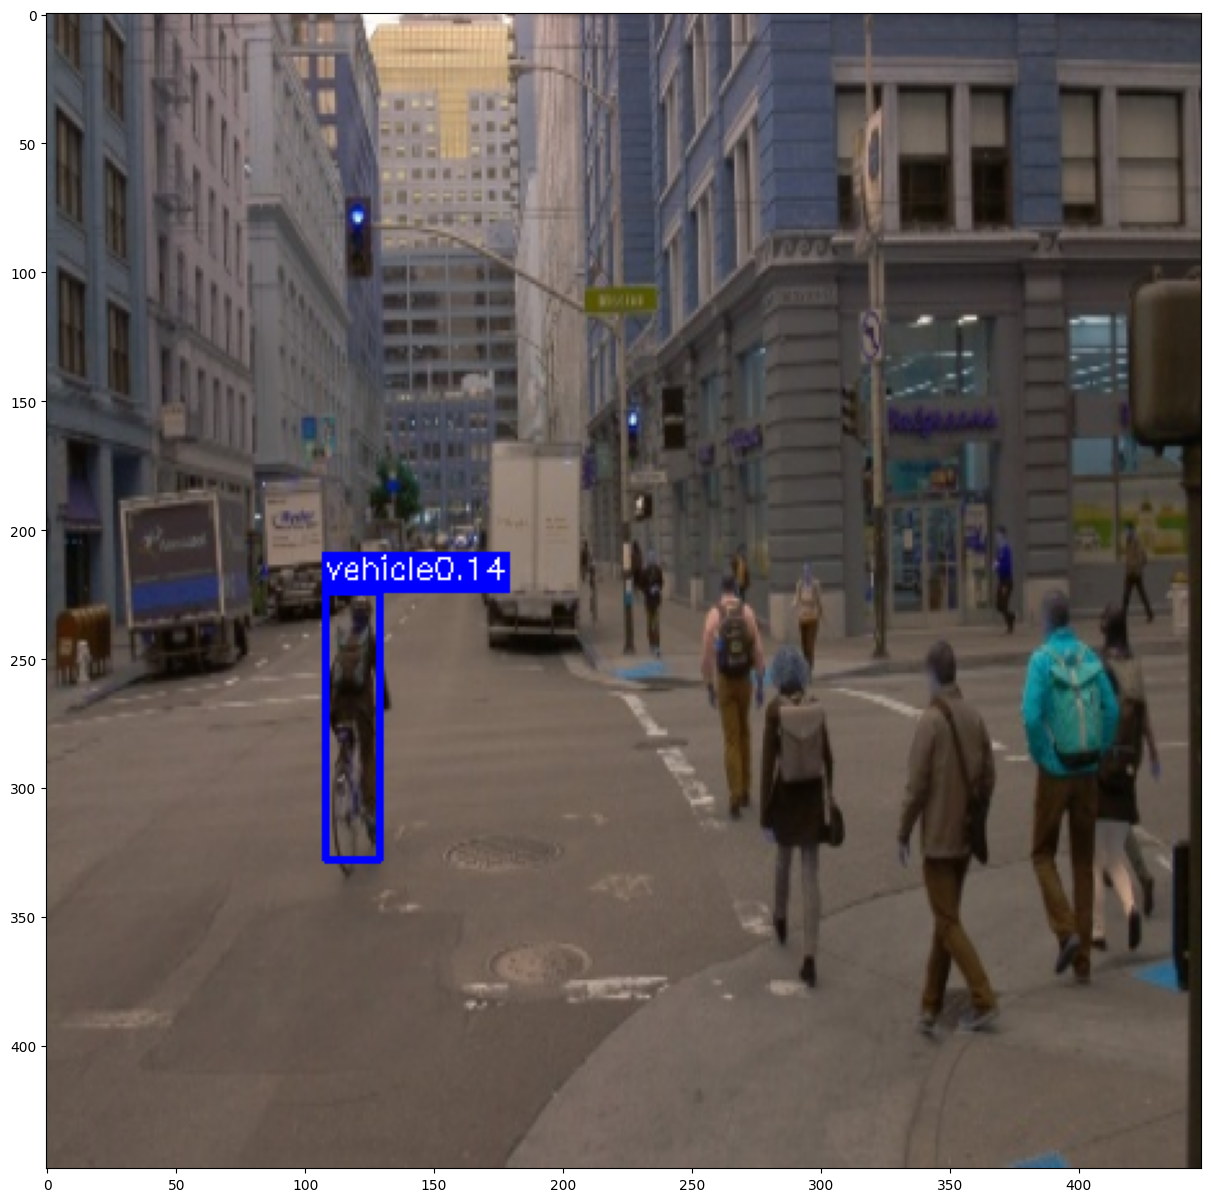

In [ ]:
net.eval()

# select random image from test set
image_name = "test"
image = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_cam_1.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (448, 448))

print('predicting...')
result = predict_image(net, image, image_name=1)
print(result)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

### Cell added to get intermediate mAP values for students

In [ ]:
network_paths = ['detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test)


In [ ]:
output_submission_csv('my_new_solution.csv', test_aps)